In [1]:
%load_ext autoreload
%autoreload 1
%autosave 60

Autosaving every 60 seconds


In [2]:
import sys
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sb
from scipy import stats
from sklearn.decomposition import PCA
import scanpy
from anndata import AnnData
import umap
import anndata
from matplotlib.colors import LogNorm, PowerNorm
from difflib import SequenceMatcher
from adjustText import adjust_text
import itertools
from sklearn.mixture import GaussianMixture
import matplotlib.scale as mscale
import matplotlib.transforms as mtransforms
import matplotlib.ticker as ticker
from matplotlib import colors
import ast
import matplotlib.cm as cm 
from scipy.stats import norm
import matplotlib.collections as mcoll
from Levenshtein import distance as levenshtein_distance

In [3]:
class SquareRootScale(mscale.ScaleBase):
    """
    ScaleBase class for generating square root scale.
    """
 
    name = 'squareroot'
 
    def __init__(self, axis, **kwargs):
        # note in older versions of matplotlib (<3.1), this worked fine.
        # mscale.ScaleBase.__init__(self)

        # In newer versions (>=3.1), you also need to pass in `axis` as an arg
        mscale.ScaleBase.__init__(self, axis)
 
    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())

    def limit_range_for_scale(self, vmin, vmax, minpos):
        return  vmin, vmax
 
    class SquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform_non_affine(self, a): 
            return (np.abs(a)**0.7) * np.sign(a)
 
        def inverted(self):
            return SquareRootScale.InvertedSquareRootTransform()
 
    class InvertedSquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform(self, a):
            return
 
        def inverted(self):
            return SquareRootScale.SquareRootTransform()
 
    def get_transform(self):
        return self.SquareRootTransform()

mscale.register_scale(SquareRootScale)

In [4]:
class SquareScale(mscale.ScaleBase):
    """
    ScaleBase class for generating square scale.
    """
 
    name = 'square'
 
    def __init__(self, axis, **kwargs):
        # note in older versions of matplotlib (<3.1), this worked fine.
        # mscale.ScaleBase.__init__(self)

        # In newer versions (>=3.1), you also need to pass in `axis` as an arg
        mscale.ScaleBase.__init__(self, axis)
 
    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())
 
    def limit_range_for_scale(self, vmin, vmax, minpos):
        return  vmin, vmax
 
    class SquareTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform_non_affine(self, a): 
            return (np.abs(a)**2) * np.sign(a)
 
        def inverted(self):
            return SquareScale.InvertedSquareTransform()
 
    class InvertedSquareTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform(self, a):
            return
 
        def inverted(self):
            return SquareScale.SquareTransform()
 
    def get_transform(self):
        return self.SquareTransform()

mscale.register_scale(SquareScale)

In [5]:
def colorline(
        x, y, z=None, cmap='copper', norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    # to check for numerical input -- this is a hack
    if not hasattr(z, "__iter__"):
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments


In [6]:
sys.path.append("/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/")

In [7]:
import rnaseq
importlib.reload(rnaseq)

<module 'rnaseq' from '/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/__init__.py'>

In [8]:
sample = "Sample_N707_-_ER2"
new_sample_name = "MCF7-labo-er2"

quant_params = "trimmed-reads-cutadapt-all/decoys-k19-1.4.0/customWh-top-3000-noWh"
quant_params = "trimmed-reads-cutadapt-all/decoys-k19-1.4.0/forceCells-3000"

genref = "human/assembly__GRCh38-hg38/annotation__gencode/gencode_34"
project = "dsp779"
cell_line="MCF7"
cond = "er2"
prefix = f"pyplot_{sample}"

In [9]:
def hammingDist(str1, str2, fillchar = '-'):
    return sum([ch1 != ch2 for (ch1,ch2) in itertools.zip_longest(str1, str2, fillvalue = fillchar)])

In [10]:
def DFS(neighbors_mtx, component, barcode, visited):

    visited[barcode] = True
    component.append(barcode)
    
    neighbors = neighbors_mtx.index.values[neighbors_mtx[barcode] == 1]
    for neighbor in neighbors :
        if visited[neighbor][0] == False:
            component = DFS(neighbors_mtx, component, neighbor, visited)
    return component


def connectedComponents(neighbors_mtx) :
    
    barcodes = neighbors_mtx.index.values
    visited = pd.DataFrame([np.repeat(False, len(barcodes))], columns = barcodes, index = ["visited"])
    all_components = []

    for barcode in barcodes :
        if visited[barcode][0] == False:
            component = []
            all_components.append(DFS(neighbors_mtx, component, barcode, visited))
    
    i = np.argsort([len(c) for c in all_components])[::-1]
    
    return np.array(all_components, dtype = object)[i]

In [11]:
def plot_errors(correction_dict, barcodes, weight_by_lib = True) :
    nucleotides = ["A","T","G","C"]
    substitutions = {f"{pos}{nt1}": {nt2 : 0 for nt2 in nucleotides} for pos in np.arange(1,13) for nt1 in nucleotides}


    for barcode1 in correction_dict.keys() :
        for barcode2 in correction_dict[barcode1] :
            if barcode2 not in barcodes :
                continue
            pos = [i for i in range(len(barcode1)) if barcode1[i] != barcode2[i]][0]
            nt1 = list(barcode1)[pos]
            nt2 = list(barcode2)[pos]
            if weight_by_lib :
                substitutions[f"{pos+1}{nt1}"][nt2] += sc.obs["raw_cb_freq"].loc[barcode2]
            else :
                substitutions[f"{pos+1}{nt1}"][nt2] += 1
    
    counts = np.array([list(list(substitutions.values())[i].values()) for i in np.arange(48)])
    fig, ax = plt.subplots(figsize=(5.5,2.5))
    ax.set_prop_cycle('color', sb.color_palette("twilight_shifted", 4))
    bottom = 0
    for c in counts.T :
        ax.bar(np.arange(48), c, width = 0.7, bottom = bottom)
        bottom += c

    ax.legend(labels = nucleotides)
    plt.xticks(np.arange(48), labels = substitutions.keys(), rotation = 90)
    plt.ylim(0,np.max(bottom)+np.max(bottom)/30)
    plt.xlim(-1.5,48.5)
    plt.tight_layout()

In [12]:
def get_intended_barcodes(errors_dict, barcodes) :
    
    intended_list = []
    errors_list = []
    for intended, erroneous in errors_dict.items(): 
        for barcode in erroneous :
            if barcode in barcodes :
                errors_list.append(barcode)
                intended_list.append(intended)
    
    return np.array(intended_list), np.array(errors_list)

In [13]:
def get_whitelist(libs) :
    
    barcodes = libs.index
    whitelist = []
    errors = []
    correction_dict = {}

#     neighbors_mtx = np.empty((len(barcodes), len(barcodes)))  
#     for i in range(len(neighbors_mtx)) :
#         barcode1 = sc.obs["CB"].values[i]
#         neighbors_mtx[i] = [hammingDist(barcode1, barcode2) == 1 for barcode2 in sc.obs_names]
#     neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = barcodes, index = barcodes, dtype=int)

    neighbors_mtx = np.empty((len(barcodes), len(barcodes)))  
    for i in range(len(neighbors_mtx)) :
        barcode1 = sc.obs["CB"].values[i]
        neighbors_mtx[i] = [barcode1 != barcode2 and ((hammingDist(barcode1, barcode2) == 1) \
                            or (levenshtein_distance(barcode1[:-1], barcode2) == 1) \
                            or (levenshtein_distance(barcode1, barcode2[:-1]) == 1)) for barcode2 in sc.obs_names]
    neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = barcodes, index = barcodes, dtype=int)

#     neighbors_mtx = np.empty((len(barcodes), len(barcodes)))  
#     for i in range(len(neighbors_mtx)) :
#         barcode1 = sc.obs["CB"].values[i]
#         neighbors_mtx[i] = [hammingDist(barcode1, barcode2) > 1 \
#                             and ((levenshtein_distance(barcode1[:-1], barcode2) == 1) \
#                             or (levenshtein_distance(barcode1, barcode2[:-1]) == 1)) for barcode2 in sc.obs_names]
#     neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = barcodes, index = barcodes, dtype=int)
    
    all_components = connectedComponents(neighbors_mtx)
    
    for component in all_components :
                
        if len(component) == 1 :
            whitelist.append(component[0])
        else :
            sorting_df = pd.DataFrame(np.array([libs.loc[component].values.ravel()]).T,\
                                      columns = ["seq_depth"], index = component)
            sorted_comp = sorting_df.sort_values(by=["seq_depth"], ascending=False).index.values
            barcode = sorted_comp[0]
            whitelist.append(barcode)
            errors.append(sorted_comp[1:])
            neighbors = neighbors_mtx.loc[barcode][sorted_comp]
            neighbors = neighbors.index.values[neighbors == 1]
            correction_dict[barcode] = neighbors

    
    return all_components, correction_dict, whitelist, np.concatenate(errors)

### Plotting parameters

In [14]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.size'] = 6

### Alevin 

In [15]:
sc = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = sample, genes_id = "ensembl_gene_id", quant_params = quant_params, genref = genref, cdna = "3' tag", exp = "sc")
sc._inplace_subset_obs(np.argsort(sc.obs["raw_cb_freq"].values)[::-1][:3000])

sc.obs_names = sc.obs["CB"]

/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt-all/decoys-k19-1.4.0/forceCells-3000
Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.


In [55]:
rnaseq.setup.annotate_samples(sc, samples_annot_name = "total_UMIs", samples_annot = sc.X.toarray().sum(1).ravel(), ow=True)
rnaseq.setup.annotate_samples(sc, samples_annot_name = "max_corr", ow=True)

Annotating total_UMIs...
Annotating max_corr...
Normalization by total UMIs...
Log2 + 1 tranformation...


In [17]:
sc.X.shape

(3000, 20305)

In [16]:
libs = sc.obs["raw_cb_freq"]

connected_components, correction_dict, whitelist, errors = get_whitelist(libs)

print(f"{len(whitelist)} barcodes in the new whitelist")

2359 barcodes in the new whitelist


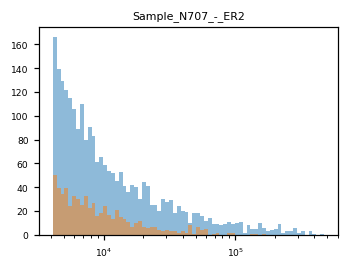

In [60]:
_,ax = plt.subplots(figsize=(3.5,2.5))
# plt.xlim(10,50000)
# plt.ylim(1,280)

tot = sc.obs["raw_cb_freq"].loc[whitelist]
logbins = rnaseq.plotting.loghist(tot, ax=ax, bins=70, alpha = 0.5);
ax.set_title(sample)
tot = sc.obs["raw_cb_freq"].loc[errors]
rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, alpha = 0.5, save_path = f"./figs/whitelist_res_hist_{sample}.pdf");

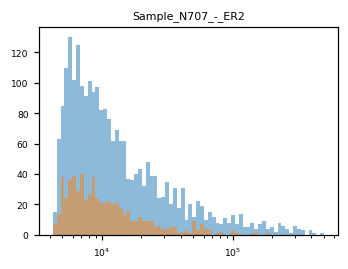

In [61]:
_,ax = plt.subplots(figsize=(3.5,2.5))
# plt.xlim(10,50000)
# plt.ylim(1,280)

tot = sc.obs["CorrectedReads"].loc[whitelist]
logbins = rnaseq.plotting.loghist(tot, ax=ax, bins=70, alpha = 0.5);
ax.set_title(sample)
tot = sc.obs["CorrectedReads"].loc[errors]
rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, alpha = 0.5, save_path = f"./figs/whitelist_res_hist_{sample}.pdf");

{'whiskers': [<matplotlib.lines.Line2D at 0x7f6b8d3400a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f6b8d2cbee0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f6b8d340880>,
 'medians': [<matplotlib.lines.Line2D at 0x7f6b8d2cb880>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f6b8d2cb310>,
 'means': []}

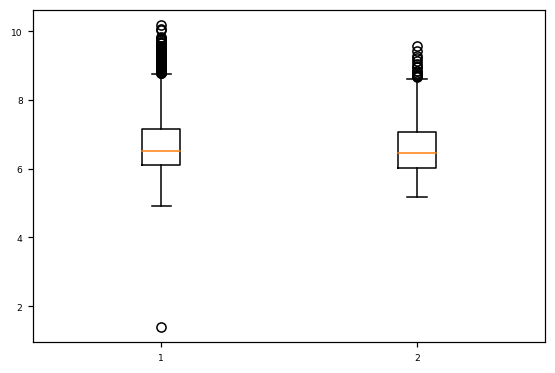

In [57]:
plt.boxplot([np.log(sc.obs["total_UMIs"].loc[whitelist]), np.log(sc.obs["total_UMIs"].loc[errors])])

In [51]:
neighbors_mtx = np.empty((len(sc.obs_names), len(sc.obs_names)))  
for i in range(len(neighbors_mtx)) :
    barcode1 = sc.obs_names.values[i]
    neighbors_mtx[i] = [(hammingDist(barcode1, barcode2) == 1) for barcode2 in sc.obs_names]
neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = sc.obs_names, index = sc.obs_names, dtype=int)

In [155]:
%%bash
pip install Levenshtein

In [156]:
neighbors_mtx = np.empty((len(sc.obs_names), len(sc.obs_names)))  
for i in range(len(neighbors_mtx)) :
    barcode1 = sc.obs_names.values[i]
    neighbors_mtx[i] = [(levenshtein_distance(barcode1, barcode2) == 1) for barcode2 in sc.obs_names]
neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = sc.obs_names, index = sc.obs_names, dtype=int)

In [157]:
barcodes = sc.obs_names

n_neighbors = (neighbors_mtx > 0).sum(1)  
n_neighbors = pd.DataFrame(np.unique(n_neighbors, return_counts=True)).T

/tmp/ipykernel_68765/1612800804.py:8: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,3000)


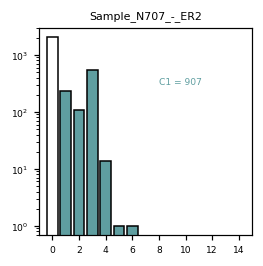

In [158]:
_,ax = plt.subplots(figsize=(2.5,2.5))
plt.title(sample)
plt.yscale('log')
ax.set_xticks(np.arange(0,15,2))
ax.bar(n_neighbors[0][0], n_neighbors[1][0], edgecolor = "black", color = "w");
ax.bar(n_neighbors[0][1:], n_neighbors[1][1:], color = "cadetblue", edgecolor = "black");
ax.text(8,300, f"C1 = {n_neighbors[1][1:].sum()}", color = "cadetblue");
plt.ylim(0,3000)
plt.xlim(-1,15)
plt.savefig(f"./figs/{prefix}_dist-nn.pdf");

In [161]:
gm = GaussianMixture(2, covariance_type="full")

X = np.array([sc.obs["DedupRate"].loc[errors]]).T

clusters = gm.fit_predict(X).astype(object)

means = pd.DataFrame({"cluster" : clusters, "dedup" : sc.obs["DedupRate"].loc[errors]}, dtype=float).groupby("cluster").mean()
sorted_cl_labels = means.sort_values(by="dedup").index.astype(int)


for cl, new_cl in zip(sorted_cl_labels, np.sort(sorted_cl_labels)) :
    clusters[clusters == cl] = str(new_cl)
    
    
sc.obs["clusters"] = np.repeat(None, sc.X.shape[0])
for barcode, cl in zip(errors, clusters) :
    sc.obs["clusters"].loc[barcode] = str(cl)

/u/davidm/VirtualEns/python_3.9.5/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [162]:
cl0 = sc.obs_names[sc.obs["clusters"] == "0"]
cl1 = sc.obs_names[sc.obs["clusters"] == "1"]

In [198]:
means = []

for o,e in zip(get_intended_barcodes(correction_dict, cl0)[0],get_intended_barcodes(correction_dict, cl0)[1]) :
    means.append((sc.obs["raw_cb_freq"].loc[o]+0.05*sc.obs["raw_cb_freq"].loc[o])*0.04)

In [199]:
np.mean(means)

4133.434307692308

In [197]:
np.mean(means)

8.954830611686372

{'whiskers': [<matplotlib.lines.Line2D at 0x7f6b735922e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f6b8e44dc70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f6b73592c10>],
 'medians': [<matplotlib.lines.Line2D at 0x7f6b73735040>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f6b73735280>],
 'means': []}

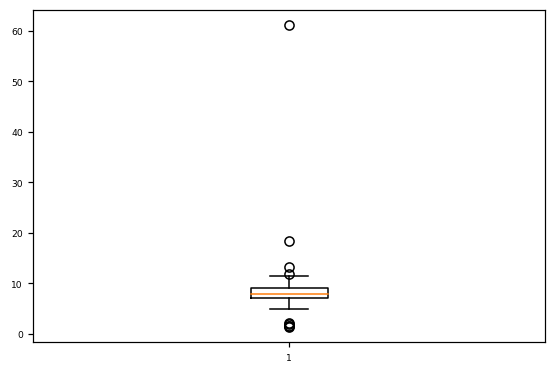

In [185]:
plt.boxplot(means)

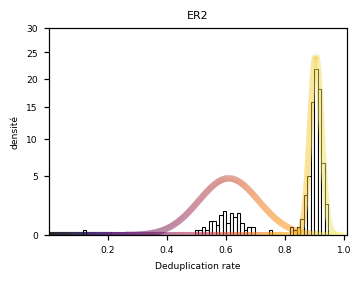

In [139]:
normalize = colors.TwoSlopeNorm(vmin=0., vcenter=.5, vmax=1)

plt.subplots(figsize=(3.5,2.5))

plt.hist(sc.obs["DedupRate"].loc[errors], bins = 70, color = "white", edgecolor = 'black', linewidth = 0.7, density=True);
plt.xlabel("Deduplication rate");
plt.ylabel("densité");


x_axis = np.arange(0, 1, 0.0001)
colorline(x_axis, norm.pdf(x_axis, gm.means_[0][0], np.sqrt(gm.covariances_[0][0])), cmap='inferno', norm=normalize, alpha = 0.6, linewidth=4)
colorline(x_axis, norm.pdf(x_axis, gm.means_[1][0], np.sqrt(gm.covariances_[1][0])), cmap='inferno', norm=normalize, alpha=0.6, linewidth=4)

plt.title("ER2")
plt.yscale("squareroot")
plt.ylim(0,30)
plt.xlim(0,1.01)
plt.xticks([0.2,0.4,0.6,0.8,1.0])
plt.savefig(f"./figs/{prefix}_distrib_dedup.pdf")

In [164]:
i_corr_max = np.argsort(np.corrcoef(sc.X.toarray()), axis = 0)[-2]
barcodes_corr_max = pd.DataFrame(sc.obs["CB"].values[i_corr_max], index = sc.obs["CB"].values)

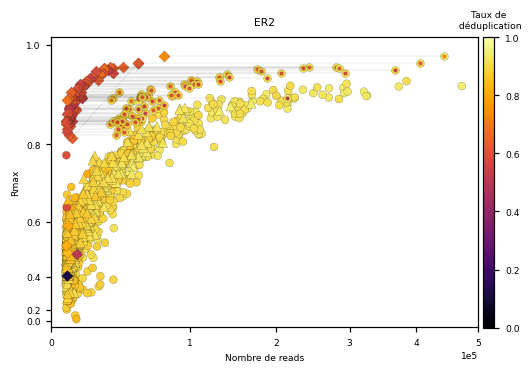

In [135]:
fig, ax = plt.subplots(figsize=(5,3.5))


# sc.obs["phred"] = total_scores.mean(1)
# color = "phred"
color = "DedupRate"
lib_type = "raw_cb_freq"
# lib_type = "total_UMIs"

# cmap = "cividis"
cmap = "inferno"
norm = colors.TwoSlopeNorm(vmin=0., vcenter=.5, vmax=1)
s = 27

edgecolors = []
linewidths = []
markers = []
sizes = []
cl0 = sc.obs_names[sc.obs["clusters"] == "0"]
cl1 = sc.obs_names[sc.obs["clusters"] == "1"]

            
for barcode in sc.obs_names :

    if barcode not in errors :
        markers.append('o')
        sizes.append(s)
    elif barcode in cl1 :
            markers.append('^')
            sizes.append(s*1.5)
    elif barcode in cl0 :
            markers.append('D')
            sizes.append(s)
            
sc.obs["marker"] = np.array(markers)
sc.obs["markersize"] = np.array(sizes)


i = 0
scatt_others = list(sc.obs_names)
for barcode in cl0 :
    neighbors = neighbors_mtx.loc[barcode]
    neighbors = neighbors.index.values[neighbors == 1]
    Rmax = barcodes_corr_max.loc[barcode][0]
    if Rmax in neighbors and sc.obs["max_corr"].loc[barcode] > 0.8 : # and sc.obs[lib_type].loc[Rmax] < 35000: 
        x = (sc.obs[lib_type].loc[barcode], sc.obs[lib_type].loc[Rmax])
        y = (sc.obs["max_corr"].loc[barcode], sc.obs["max_corr"].loc[Rmax])
        ax.plot(x,y, linewidth = 0.1, color = "black", label = "max R & hd =1 with gm1" if i == 0 else "", zorder = 7, alpha = 0.5)
        ax.scatter(sc.obs[lib_type].loc[Rmax], sc.obs["max_corr"].loc[Rmax], marker = sc.obs.loc[Rmax]["marker"], \
                   s = sc.obs.loc[Rmax]["markersize"], c = sc.obs[color].loc[Rmax], edgecolors = 'black', linewidths = 0.1, \
                   cmap = cmap, norm = norm, zorder = 5)
        ax.scatter(sc.obs[lib_type].loc[Rmax], sc.obs["max_corr"].loc[Rmax], marker = '.', c = sc.obs[color].loc[barcode], \
                   edgecolors = 'black', linewidths = 0.05, cmap = cmap, norm = norm, s = 25, zorder = 5)
        ax.scatter(sc.obs[lib_type].loc[barcode], sc.obs["max_corr"].loc[barcode], marker = sc.obs.loc[barcode]["marker"], \
                   s = sc.obs.loc[barcode]["markersize"], c = sc.obs[color].loc[barcode], edgecolors = 'black', \
                   linewidths = 0.1, cmap = cmap, norm = norm, zorder = 5)
        i += 1
        if Rmax in scatt_others : scatt_others.remove(Rmax)
        if barcode in scatt_others : scatt_others.remove(barcode)

            
ax.set_xlim(xmin = 0, xmax=500000)
ax.set_ylim(ymin=-0.15, ymax=1.015)
ax.set_yscale("square")
ax.set_xscale("squareroot")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))



rnaseq.plotting.scatter(sc.obs.loc[scatt_others][lib_type].values, sc.obs.loc[scatt_others]["max_corr"].values, sc.obs.loc[scatt_others][color].values, marker = sc.obs.loc[scatt_others]["marker"].values, \
            linewidth = 0.1, edgecolor = 'black', norm = norm, fig=fig, s = sc.obs.loc[scatt_others]["markersize"].values, \
            cmap = cmap, order_color = "descending", order_marker = {'D':3, 'o':1, '^':2, 'v':4}, \
            color_title = "Taux de\n déduplication", xlabel = "Nombre de reads", ylabel = "Rmax", title = "ER2")    



plt.savefig(f"./figs/{prefix}_{lib_type}-max-corr_gm-clusters.pdf")

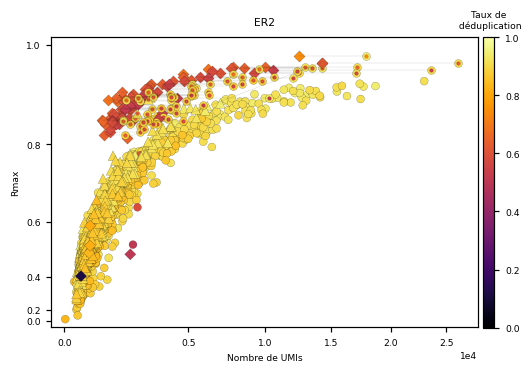

In [136]:
fig, ax = plt.subplots(figsize=(5,3.5))


# sc.obs["phred"] = total_scores.mean(1)
# color = "phred"
color = "DedupRate"
lib_type = "total_UMIs"

# cmap = "cividis"
cmap = "inferno"
norm = colors.TwoSlopeNorm(vmin=0., vcenter=.5, vmax=1)
s = 27

edgecolors = []
linewidths = []
markers = []
sizes = []
cl0 = sc.obs_names[sc.obs["clusters"] == "0"]
cl1 = sc.obs_names[sc.obs["clusters"] == "1"]

            
for barcode in sc.obs_names :

    if barcode not in errors :
        markers.append('o')
        sizes.append(s)
    elif barcode in cl1 :
            markers.append('^')
            sizes.append(s*1.5)
    elif barcode in cl0 :
            markers.append('D')
            sizes.append(s)
            
sc.obs["marker"] = np.array(markers)
sc.obs["markersize"] = np.array(sizes)


i = 0
scatt_others = list(sc.obs_names)
for barcode in cl0 :
    neighbors = neighbors_mtx.loc[barcode]
    neighbors = neighbors.index.values[neighbors == 1]
    Rmax = barcodes_corr_max.loc[barcode][0]
    if Rmax in neighbors and sc.obs["max_corr"].loc[barcode] > 0.8 : # and sc.obs[lib_type].loc[Rmax] < 35000: 
        x = (sc.obs[lib_type].loc[barcode], sc.obs[lib_type].loc[Rmax])
        y = (sc.obs["max_corr"].loc[barcode], sc.obs["max_corr"].loc[Rmax])
        ax.plot(x,y, linewidth = 0.1, color = "black", label = "max R & hd =1 with gm1" if i == 0 else "", zorder = 7, alpha = 0.5)
        ax.scatter(sc.obs[lib_type].loc[Rmax], sc.obs["max_corr"].loc[Rmax], marker = sc.obs.loc[Rmax]["marker"], \
                   s = sc.obs.loc[Rmax]["markersize"], c = sc.obs[color].loc[Rmax], edgecolors = 'black', linewidths = 0.1, \
                   cmap = cmap, norm = norm, zorder = 5)
        ax.scatter(sc.obs[lib_type].loc[Rmax], sc.obs["max_corr"].loc[Rmax], marker = '.', c = sc.obs[color].loc[barcode], \
                   edgecolors = 'black', linewidths = 0.05, cmap = cmap, norm = norm, s = 25, zorder = 5)
        ax.scatter(sc.obs[lib_type].loc[barcode], sc.obs["max_corr"].loc[barcode], marker = sc.obs.loc[barcode]["marker"], \
                   s = sc.obs.loc[barcode]["markersize"], c = sc.obs[color].loc[barcode], edgecolors = 'black', \
                   linewidths = 0.1, cmap = cmap, norm = norm, zorder = 5)
        i += 1
        if Rmax in scatt_others : scatt_others.remove(Rmax)
        if barcode in scatt_others : scatt_others.remove(barcode)

            
ax.set_xlim(xmin = -200, xmax=28000)
ax.set_ylim(ymin=-0.15, ymax=1.015)
ax.set_yscale("square")
ax.set_xscale("squareroot")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))



rnaseq.plotting.scatter(sc.obs.loc[scatt_others][lib_type].values, sc.obs.loc[scatt_others]["max_corr"].values, sc.obs.loc[scatt_others][color].values, marker = sc.obs.loc[scatt_others]["marker"].values, \
            linewidth = 0.1, edgecolor = 'black', norm = norm, fig=fig, s = sc.obs.loc[scatt_others]["markersize"].values, \
            cmap = cmap, order_color = "descending", order_marker = {'D':3, 'o':1, '^':2, 'v':4}, \
            color_title = "Taux de\n déduplication", xlabel = "Nombre de UMIs", ylabel = "Rmax", title = "ER2")    



plt.savefig(f"./figs/{prefix}_{lib_type}-max-corr_gm-clusters.pdf")

### Errors patterns

In [113]:
n_neighbors_cl0 = neighbors_mtx.loc[cl0].sum(0)
stats.pearsonr(n_neighbors_cl0, sc.obs["raw_cb_freq"].values)

(0.30198897900590127, 2.679034607966613e-64)

In [114]:
n_neighbors_cl1 = neighbors_mtx.loc[cl1].sum(0)
stats.pearsonr(n_neighbors_cl1, sc.obs["raw_cb_freq"].values)

(-0.008794140602650035, 0.6301729099912378)

In [115]:
n_neighbors = neighbors_mtx.sum(0)
stats.pearsonr(n_neighbors, sc.obs["raw_cb_freq"].values)

(0.026324766403731627, 0.1494390330908407)

In [116]:
np.save("n_neighbors.npy", n_neighbors)
np.save("raw_cb_freq.npy", sc.obs["raw_cb_freq"].values)

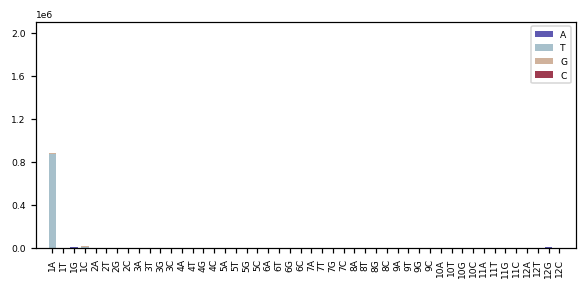

In [121]:
plot_errors(correction_dict, cl0)
plt.ylim(0, 2.1*1e6)
plt.yticks(np.arange(0,2.2,0.4)*1e6)
plt.savefig(f"./figs/{prefix}_cl1_errors.pdf")

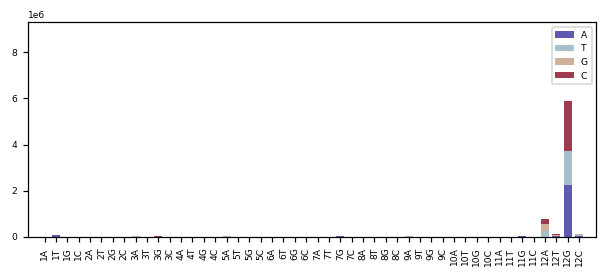

In [122]:
plot_errors(correction_dict, cl1);
plt.ylim(0, 9.3*1e6)
plt.yticks(np.arange(0,10,2)*1e6)
plt.savefig(f"./figs/{prefix}_cl2_errors.pdf")

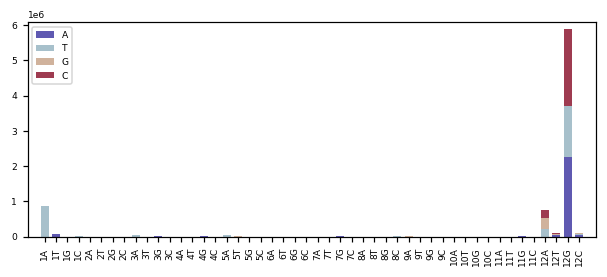

In [120]:
plot_errors(correction_dict, sc.obs_names);
plt.savefig(f"./figs/{prefix}_all_errors.pdf")

In [112]:
project_path = "/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779"
x = pd.read_csv(f"{project_path}/raw-fastqs/{sample}/new_phreds.csv")

In [ ]:
total_scores = []

for barcode in sc.obs["CB"] :
    phreds = ast.literal_eval(x[barcode].values[0])[:10000]
    scores = []
    for phred in phreds :
        scores.append([ord(str(s))-33 for s in phred[:12]])
    total_scores.append(np.mean(scores, axis = 0))

total_scores = np.array(total_scores)

In [ ]:
corrected_low_dedup_phreds = np.array(total_scores[[b in cl0 for b in sc.obs_names]])
corrected_normal_dedup_phreds = np.array(total_scores[[b in cl1 for b in sc.obs_names]])
random_phreds = np.array(total_scores[[b in whitelist for b in sc.obs_names]])

In [ ]:
ax = plt.subplots(figsize=(3.5, 2.5))

flierprops = {'marker':'.', 'markersize':1, 'markeredgecolor':'none', 'markerfacecolor':'black'}
medianprops = {'color':'black', 'linewidth':0.8}
whiskerprops = {'linewidth': 0.5}
capprops = {'linewidth': 0.5}


bp = plt.boxplot(corrected_low_dedup_phreds, positions = np.arange(0,48,4), widths = 0.7, patch_artist = True,\
                 boxprops={'facecolor': 'lightskyblue', 'linewidth': 0.7},\
                 flierprops=flierprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)

bp = plt.boxplot(corrected_normal_dedup_phreds, positions = np.arange(1,48,4), widths = 0.7, patch_artist = True,\
                 boxprops={'facecolor': 'dodgerblue', 'linewidth': 0.7},\
                 flierprops=flierprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)

bp = plt.boxplot(random_phreds, positions = np.arange(2,48,4), widths = 0.7, patch_artist = True,\
                 boxprops={'facecolor': 'lightgray', 'linewidth': 0.7},\
                 flierprops=flierprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)

plt.xticks(np.arange(1,48,4), labels = np.arange(1,13))
plt.xlim(-1, 47);

In [90]:
project_path = "/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779"
x = pd.read_csv(f"{project_path}/raw-fastqs/{sample}/new_umis.csv")

In [91]:
low_dedup_shared_umis_e = []
random_low_dedup_shared_umis_e = []

normal_dedup_shared_umis_e = []
random_normal_dedup_shared_umis_e = []


data = sc.obs["total_UMIs"].loc[np.setdiff1d(whitelist, correction_dict.keys())].to_dict()

for o,e in zip(get_intended_barcodes(correction_dict, cl0)[0], get_intended_barcodes(correction_dict, cl0)[1]) :
    
    cb1 = min(data.items(), key=lambda x: abs(sc.obs["total_UMIs"].loc[o] - x[1]))[0]
    cb2 = min(data.items(), key=lambda x: abs(sc.obs["total_UMIs"].loc[e] - x[1]))[0]
    data.pop(cb2, None)
    umis_cb1 = np.unique(np.concatenate([ast.literal_eval(x[cb1].values[chunk]) for chunk in range(x.shape[0])]))
    umis_cb2 = np.unique(np.concatenate([ast.literal_eval(x[cb2].values[chunk]) for chunk in range(x.shape[0])]))
    shared_umis = len(np.intersect1d(umis_cb1, umis_cb2))
    random_low_dedup_shared_umis_e.append(shared_umis/len(umis_cb2))
    
    umis_e = np.unique(np.concatenate([ast.literal_eval(x[e].values[chunk]) for chunk in range(x.shape[0])]))
    umis_o = np.unique(np.concatenate([ast.literal_eval(x[o].values[chunk]) for chunk in range(x.shape[0])]))
    shared_umis = len(np.intersect1d(umis_e, umis_o))
    low_dedup_shared_umis_e.append(shared_umis/len(umis_e))



data = sc.obs["total_UMIs"].loc[np.setdiff1d(whitelist, correction_dict.keys())].to_dict()

for o,e in zip(get_intended_barcodes(correction_dict, cl1)[0], get_intended_barcodes(correction_dict, cl1)[1]) :
    
    cb1 = min(data.items(), key=lambda x: abs(sc.obs["total_UMIs"].loc[o] - x[1]))[0]
    cb2 = min(data.items(), key=lambda x: abs(sc.obs["total_UMIs"].loc[e] - x[1]))[0]
    data.pop(cb2, None)
    umis_cb1 = np.unique(np.concatenate([ast.literal_eval(x[cb1].values[chunk]) for chunk in range(x.shape[0])]))
    umis_cb2 = np.unique(np.concatenate([ast.literal_eval(x[cb2].values[chunk]) for chunk in range(x.shape[0])]))
    shared_umis = len(np.intersect1d(umis_cb1, umis_cb2))
    random_normal_dedup_shared_umis_e.append(shared_umis/len(umis_cb2))
    
    umis_e = np.unique(np.concatenate([ast.literal_eval(x[e].values[chunk]) for chunk in range(x.shape[0])]))
    umis_o = np.unique(np.concatenate([ast.literal_eval(x[o].values[chunk]) for chunk in range(x.shape[0])]))
    shared_umis = len(np.intersect1d(umis_e, umis_o))
    normal_dedup_shared_umis_e.append(shared_umis/len(umis_e))




# random_shared_umis = []
# for i in range(len(cl1)):
#     cb1,cb2 = np.random.choice(whitelist, 2, replace = False)
#     umis_cb1 = np.unique(np.concatenate([ast.literal_eval(x[cb1].values[chunk]) for chunk in range(x.shape[0])]))
#     umis_cb2 = np.unique(np.concatenate([ast.literal_eval(x[cb2].values[chunk]) for chunk in range(x.shape[0])]))
#     n_umis = min([len(umis_cb2),len(umis_cb2)])
#     shared_umis = len(np.intersect1d(umis_cb1, umis_cb2))
#     random_shared_umis.append(shared_umis/n_umis)

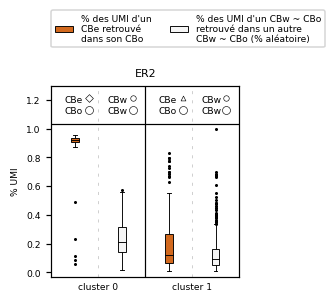

In [93]:
_, ax = plt.subplots(figsize=(2.2, 2.3))



bp = plt.boxplot(low_dedup_shared_umis_e, positions = [-0.25], widths = 0.25, patch_artist = True,\
                 boxprops={'facecolor': 'chocolate', 'color' : 'black', 'linewidth': 0.6},\
                 whiskerprops = {'linewidth': 0.6, 'color':'black'},\
                 capprops = {'linewidth': 0.6, 'color':'black'},\
                 medianprops = {'color' : 'black', 'linewidth' : 0.6},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'black', 'markeredgecolor':'black'})

bp = plt.boxplot(random_low_dedup_shared_umis_e, positions = [1.25], widths = 0.25, patch_artist = True,\
                 boxprops={'facecolor': 'whitesmoke', 'color' : 'black', 'linewidth': 0.6},\
                 whiskerprops = {'linewidth': 0.6, 'color':'black'},\
                 capprops = {'linewidth': 0.6, 'color':'black'},\
                 medianprops = {'color' : 'black', 'linewidth' : 0.6},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'black', 'markeredgecolor':'black'})



bp1 = plt.boxplot(normal_dedup_shared_umis_e, positions = [2.75], widths = 0.25, patch_artist = True,\
                 boxprops={'facecolor': 'chocolate', 'color' : 'black', 'linewidth': 0.6},\
                 whiskerprops = {'linewidth': 0.6, 'color':'black'},\
                 capprops = {'linewidth': 0.6, 'color':'black'},\
                 medianprops = {'color' : 'black', 'linewidth' : 0.6},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'black', 'markeredgecolor':'black'})
bp2 = plt.boxplot(random_normal_dedup_shared_umis_e, positions = [4.25], widths = 0.25, patch_artist = True,\
                 boxprops={'facecolor': 'whitesmoke', 'color' : 'black', 'linewidth': 0.6},\
                 whiskerprops = {'linewidth': 0.6, 'color':'black'},\
                 capprops = {'linewidth': 0.6, 'color':'black'},\
                 medianprops = {'color' : 'black', 'linewidth' : 0.6},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'black', 'markeredgecolor':'black'})



ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ["% des UMI d'un\nCBe retrouvé\ndans son CBo", \
                    "% des UMI d'un CBw ~ CBo\nretrouvé dans un autre\nCBw ~ CBo (% aléatoire)"],loc=(0,1.2), ncol=2)



plt.axhline(y=1.03, linewidth = 0.8, color="black")
plt.axvline(x=0.5, linewidth = 0.4, color="black", ls=(0, (5, 10)), alpha = 0.3)
plt.axvline(x=2, linewidth = 0.8, color="black")
plt.axvline(x=3.5, linewidth = 0.4, color="black", ls=(0, (5, 10)), alpha = 0.3)



plt.scatter([1.6,4.6],np.repeat(1.213,2), marker='o', s = 13, color='white', edgecolors='black', linewidths=0.4)
plt.scatter([0.2,1.6,3.2,4.6],np.repeat(1.13,4), marker='o', s = 27, color='white', edgecolors='black', linewidths=0.4)
plt.scatter(0.2, 1.213, marker='D', s = 13, color='white', edgecolors='black', linewidths=0.4)
plt.scatter(3.2, 1.213, marker='^', s = 10, color='white', edgecolors='black', linewidths=0.4)


plt.text(-0.58, 1.185, "CBe")
plt.text(-0.58, 1.11, "CBo")
plt.text(x = 2.43, y = 1.185, s = "CBe")
plt.text(x = 2.43, y = 1.11, s = "CBo")

plt.text(0.8, 1.185, "CBw")
plt.text(0.8, 1.11, "CBw")
plt.text(3.8, 1.185, "CBw")
plt.text(3.8, 1.11, "CBw")


plt.xticks([0.5,3.5,6.5], labels=["cluster 0", "cluster 1", "cluster 2"])
ax.tick_params(axis='x', length = 0)

plt.xlim(-1,5)
plt.ylim(-0.03,1.3)

plt.ylabel("% UMI")
plt.title("ER2")

plt.savefig(f"./figs/{prefix}_shared_umis.pdf")

In [200]:
project_path = "/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779"
x = pd.read_csv(f"{project_path}/raw-fastqs/{sample}/new_phreds.csv")

In [51]:
total_scores = []

for barcode in sc.obs["CB"] :
#     phreds = np.concatenate([ast.literal_eval(chunk) for chunk in x[barcode].values])
    phreds = ast.literal_eval(x[barcode].values[0])[:10000]
    scores = []
    for phred in phreds :
        scores.append([ord(str(s))-33 for s in phred[:12]])
    total_scores.append(np.mean(scores, axis = 0))

total_scores = np.array(total_scores)

In [52]:
corrected_low_dedup_phreds = np.array(total_scores[[b in cl0 for b in sc.obs_names]])
corrected_normal_dedup_phreds = np.array(total_scores[[b in cl1 for b in sc.obs_names]])
random_phreds = np.array(total_scores[[b in whitelist for b in sc.obs_names]])

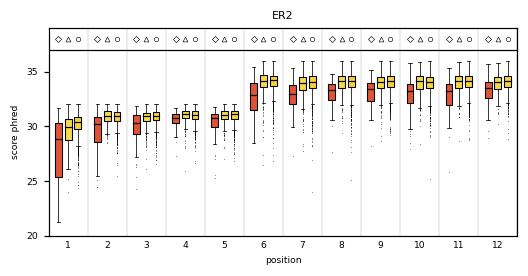

In [95]:
_, ax = plt.subplots(figsize=(5.5, 2.5))

flierprops = {'marker':'.', 'markersize':1, 'markeredgecolor':'none', 'markerfacecolor':'black'}
medianprops = {'color':'black', 'linewidth':0.8}
whiskerprops = {'linewidth': 0.5}
capprops = {'linewidth': 0.5}

cmap = cm.get_cmap('inferno')


rgba = cmap(sc.obs["DedupRate"].loc[cl0].mean())
bp = plt.boxplot(corrected_low_dedup_phreds, positions = np.arange(0,48,4), widths = 0.7, patch_artist = True,\
                 boxprops={'facecolor': rgba, 'linewidth': 0.7},\
                 flierprops=flierprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
plt.scatter(np.arange(0,48,4),np.repeat(38,12), marker='D', s = 8, color='white', edgecolors='black', linewidths=0.4)


rgba = cmap(sc.obs["DedupRate"].loc[cl1].mean())
bp = plt.boxplot(corrected_normal_dedup_phreds, positions = np.arange(1,48,4), widths = 0.7, patch_artist = True,\
                 boxprops={'facecolor': rgba, 'linewidth': 0.7},\
                 flierprops=flierprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
plt.scatter(np.arange(1,48,4),np.repeat(38,12), marker='^', s = 10, color='white', edgecolors='black', linewidths=0.4)


rgba = cmap(sc.obs["DedupRate"].loc[whitelist].mean())
bp = plt.boxplot(random_phreds, positions = np.arange(2,48,4), widths = 0.7, patch_artist = True,\
                 boxprops={'facecolor': rgba, 'linewidth': 0.7},\
                 flierprops=flierprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
plt.scatter(np.arange(2,48,4),np.repeat(38,12), marker='o', s = 8, color='white', edgecolors='black', linewidths=0.4)


plt.xticks(np.arange(1,48,4), labels = np.arange(1,13))
ax.tick_params(axis='x', length = 0)

plt.axhline(y=37, linewidth = 0.8, color="black")
for x in np.arange(3,48,4) :
    plt.axvline(x=x, linewidth = 0.3, color="black", alpha = 0.3)

    
plt.yticks([20,25,30,35])
plt.xlim(-1, 47);
plt.ylim(20,39)
plt.xlabel("position")
plt.ylabel("score phred")
plt.title("ER2")

plt.savefig(f"./figs/{prefix}_phreds.pdf")

In [96]:
del x

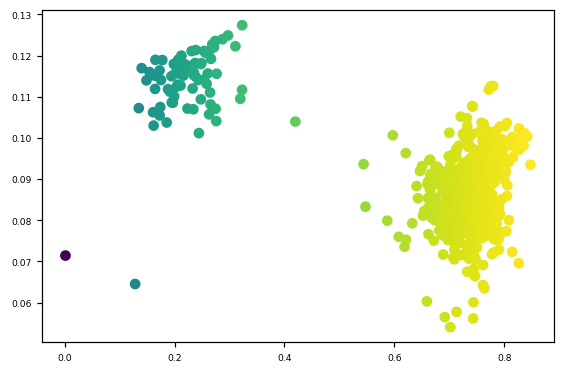

In [45]:
plt.scatter(sc.obs["DedupRate"].loc[errors]**3, sc.obs["max_corr"].loc[errors]/np.log(sc.obs["total_UMIs"].loc[errors]), c = sc.obs["DedupRate"].loc[errors])

### Results new whitelist

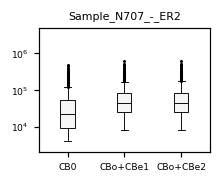

In [17]:
a = np.array(sc.obs.loc[list(correction_dict.keys())]["raw_cb_freq"])
b = np.array([sc.obs.loc[list(correction_dict.keys())[i]]["raw_cb_freq"] + sc.obs.loc[list(correction_dict.values())[i]]["raw_cb_freq"].sum() for i in range(len(correction_dict))])
c = np.array([sc.obs.loc[connected_components[i]]["raw_cb_freq"].sum() for i in range(len(connected_components)) if connected_components[i][0] in correction_dict.keys()])

plt.subplots(figsize = (2,1.5))
plt.boxplot([a,b,c], labels=["CB0", "CBo+CBe1", "CBo+CBe2"], widths = 0.25, patch_artist = True,\
                 boxprops={'facecolor': 'whitesmoke', 'color' : 'black', 'linewidth': 0.6},\
                 whiskerprops = {'linewidth': 0.6, 'color':'black'},\
                 capprops = {'linewidth': 0.6, 'color':'black'},\
                 medianprops = {'color' : 'black', 'linewidth' : 0.6},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'black', 'markeredgecolor':'black'})

plt.title(sample)
plt.ylim(2000,5e6)
plt.yscale('log')
plt.minorticks_off()
plt.savefig(f"./figs/percent_increase_lib_corr_{sample}.pdf")

In [18]:
np.mean((b-a)/a)

1.1297675463449264

In [20]:
np.mean((c-b)/b)

0.00792057288508304

In [21]:
len(list(correction_dict.keys()))

293

In [22]:
len(np.concatenate(list(correction_dict.values())))

627

In [23]:
len(errors)

641

In [24]:
len(np.setdiff1d(errors, np.concatenate(list(correction_dict.values()))))

14

In [108]:
f = pd.read_csv(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt/pc-decoys-k31-1.4.0/default/{sample}/alevin/raw_cb_frequency.txt", delimiter='\t', header = None)

In [147]:
k = pd.read_csv(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt/pc-decoys-k31-1.4.0/default/{sample}/alevin/quants_mat_rows.txt", header=None)
w = pd.read_csv(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt/pc-decoys-k31-1.4.0/default/{sample}/alevin/whitelist.txt", header=None)

In [148]:
len(k)

347

In [149]:
len(w)

107

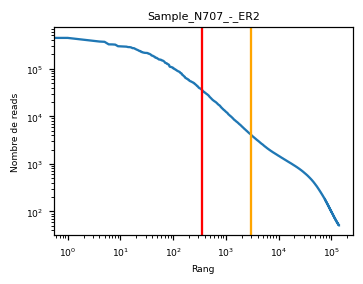

In [134]:
plt.subplots(figsize=(3.5,2.5))
plt.plot(f[1].values[f[1].values>50])
plt.yscale("log");
plt.xscale("log");
plt.axvline(3000, color="orange")
plt.axvline(len(k), color='red')
plt.title(sample)
plt.xlabel("Rang")
plt.ylabel("Nombre de reads")
plt.savefig(f"./figs/{prefix}_knee1.pdf")

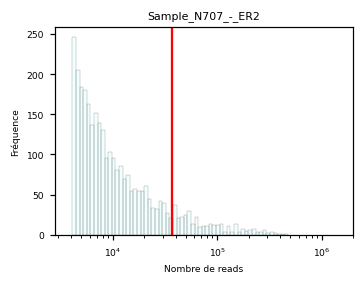

In [146]:
_,ax = plt.subplots(figsize=(3.5,2.5))
plt.axvline(f[1][len(k)], color='red')
rnaseq.plotting.loghist(f[1].values[:3000], bins=60, ax=ax, linewidth=0.1, edgecolor='black', fc = (0.5,1,1,0.1));
plt.title(sample)
plt.xlim(2800,2e6)
plt.ylabel("Fréquence")
plt.xlabel("Nombre de reads")
plt.savefig(f"./figs/{prefix}_knee3.pdf");

In [27]:
quant_params_new = "trimmed-reads-cutadapt/pc-decoys-k31-1.4.0/customWh-top-3000-noWh"
sc_new = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = sample, genes_id = "ensembl_gene_id", quant_params = quant_params_new, genref = genref, cdna = "3' tag", exp = "sc")
rnaseq.setup.annotate_samples(sc_new, samples_annot_name = "total_UMIs", samples_annot = sc_new.X.toarray().sum(1).ravel())
rnaseq.setup.annotate_samples(sc_new, samples_annot_name = "max_corr", ow=True)

/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt/pc-decoys-k31-1.4.0/customWh-top-3000-noWh
Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
Annotating total_UMIs...
Annotating max_corr...
Normalization by total UMIs...
Log2 + 1 tranformation...


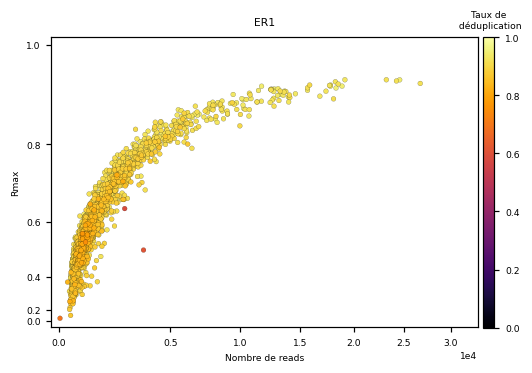

In [28]:
fig, ax = plt.subplots(figsize=(5,3.5))

color = "DedupRate"
lib_type = "total_UMIs"
# lib_type = "total_UMIs"

# cmap = "cividis"
cmap = "inferno"
norm = colors.TwoSlopeNorm(vmin=0., vcenter=.5, vmax=1)
s = 27

ax.set_yscale("square")
ax.set_xscale("squareroot")
ax.set_xlim(xmin =-100, xmax=33000)
ax.set_ylim(ymin=-0.15, ymax=1.015)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))



rnaseq.plotting.scatter(sc_new.obs[lib_type].values, sc_new.obs["max_corr"].values, sc_new.obs[color].values, \
            linewidth = 0.1, edgecolor = 'black', norm = norm, fig=fig, s = 10, \
            cmap = cmap, order_color = "descending", \
            color_title = "Taux de\n déduplication", xlabel = "Nombre de reads", ylabel = "Rmax", title = "ER1")    



plt.savefig(f"./figs/{prefix}_{lib_type}-max-corr_after-correction.pdf")

In [25]:
import json
quant_params = "trimmed-reads-cutadapt-all/decoys-k19-1.4.0/default"

with open(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params}/{sample}/aux_info/alevin_meta_info.json") as f:
    alevin_meta_info = json.load(f)

knee = alevin_meta_info["initial_whitelist"]

In [26]:
np.sort(sc.obs["raw_cb_freq"])[::-1][knee]

74632

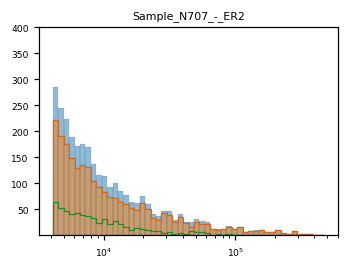

In [95]:
_,ax = plt.subplots(figsize=(3.5,2.5))
ax.set_title(sample)

# plt.xlim(3000,600000)
plt.ylim(1,400)

tot = sc.obs["raw_cb_freq"]
logbins = rnaseq.plotting.loghist(tot, ax=ax, bins=50, lw = 0.1, edgecolor = "black", color = 'tab:blue', alpha = 0.5);

tot = sc_new.obs["raw_cb_freq"]
logbins = rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, lw = 0.1, edgecolor = "black", color = 'tab:orange', alpha = 0.5);

tot = sc.obs["raw_cb_freq"].loc[whitelist]
rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, lw=0.8, edgecolor = "chocolate",  histtype = "step");

tot = sc.obs["raw_cb_freq"].loc[errors]
rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, lw=0.8, edgecolor = "forestgreen",  histtype = "step", save_path = f"./figs/whitelist_res_hist_0_{sample}.pdf");


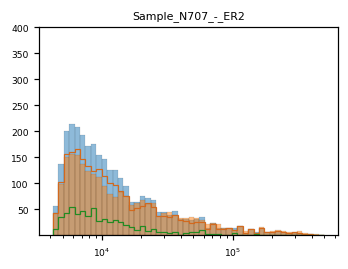

In [94]:
_,ax = plt.subplots(figsize=(3.5,2.5))
ax.set_title(sample)

# plt.xlim(3000,600000)
plt.ylim(1,400)

tot = sc.obs["CorrectedReads"]
logbins = rnaseq.plotting.loghist(tot, ax=ax, bins=50, lw = 0.1, edgecolor = "black", color = 'tab:blue', alpha = 0.5);

tot = sc_new.obs["CorrectedReads"]
logbins = rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, lw = 0.1, edgecolor = "black", color = 'tab:orange', alpha = 0.5);

tot = sc.obs["CorrectedReads"].loc[whitelist]
rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, lw=0.8, edgecolor = "chocolate",  histtype = "step");

tot = sc.obs["CorrectedReads"].loc[errors]
rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, lw=0.8, edgecolor = "forestgreen",  histtype = "step", save_path = f"./figs/whitelist_res_hist_1_{sample}.pdf");

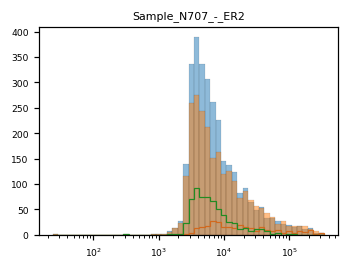

In [107]:
_,ax = plt.subplots(figsize=(3.5,2.5))
ax.set_title(sample)

# plt.xlim(10,600000)
# plt.ylim(1,400)

tot = sc.obs["MappedReads"]
logbins = rnaseq.plotting.loghist(tot, ax=ax, bins=50, lw = 0.1, edgecolor = "black", color = 'tab:blue', alpha = 0.5);

tot = sc_new.obs["MappedReads"]
logbins = rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, lw = 0.1, edgecolor = "black", color = 'tab:orange', alpha = 0.5);

tot = sc.obs["MappedReads"].loc[whitelist]
rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, lw=0.8, edgecolor = "chocolate",  histtype = "step");

# tot = sc.obs["MappedReads"].loc[np.setdiff1d(whitelist,list(correction_dict.keys()))]
# rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, lw=0.8, edgecolor = "chocolate",  histtype = "step");

tot = sc.obs["MappedReads"].loc[errors]
rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, lw=0.8, edgecolor = "forestgreen",  histtype = "step", save_path = f"./figs/whitelist_res_hist_2_{sample}.pdf");

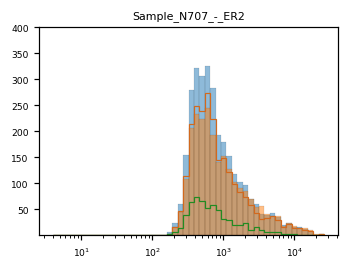

In [92]:
_,ax = plt.subplots(figsize=(3.5,2.5))
ax.set_title(sample)

# plt.xlim(10,50000)
plt.ylim(1,400)

tot = sc.obs["DeduplicatedReads"]
logbins = rnaseq.plotting.loghist(tot, ax=ax, bins=50, lw = 0.1, edgecolor = "black", color = 'tab:blue', alpha = 0.5);

tot = sc_new.obs["DeduplicatedReads"]
logbins = rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, lw = 0.1, edgecolor = "black", color = 'tab:orange', alpha = 0.5);

tot = sc.obs["DeduplicatedReads"].loc[whitelist]
rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, lw=0.8, edgecolor = "chocolate",  histtype = "step");

tot = sc.obs["DeduplicatedReads"].loc[errors]
rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, lw=0.8, edgecolor = "forestgreen",  histtype = "step",save_path = f"./figs/whitelist_res_hist_3_{sample}.pdf");